In [26]:
#import Pkg
#Pkg.add("JuMP")
#Pkg.add("GLPK")
#Pkg.add("Gruobi")
#Pkg.add("DataFrames")
#Pkg.add("CSV")

In [27]:
using JuMP, GLPK
using DataFrames
using CSV

In [28]:
#load cost data
con_generation = CSV.File("../data/conventional_generators.csv") |> DataFrame

#load wind_technicaldata
wind_generation = CSV.File("../data/wind_farms.csv") |> DataFrame

# load wind profile
wind_profile = CSV.File("../data/wind_powerprofile_200.csv") |> DataFrame

# batteries
battery = CSV.File("../data/Battery.csv") |> DataFrame


Row,Battery,Location(Node),Production cost,Capacity[MWh],Power[MW]
,Int64,Int64,Int64,Int64,Int64
1,1,6,10,100,15
2,2,10,10,50,10
3,3,12,10,50,10
4,4,15,10,75,20
5,5,17,10,25,5


In [29]:
#demand bids
name = "demand_hour_0.csv"
demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame
 
# number of convential generators
G = size(con_generation, 1)

# number of demand
D = size(demand_bids, 1)

# number of wind generators
W = size(wind_generation, 1)

# number of batteries
B = size(battery, 1)


5

In [30]:
# Initialize the DataFrame directly without dynamic column names
result_df = DataFrame(hour = Int[])
equilibrium_df = DataFrame(hour = Int[], market_price = Float64[], total_demand = Float64[], total_bat = Float64[], total_supply = Float64[])

# For x variables, manually add each column. This is a one-time setup.
for i in 1:G
    result_df[!, Symbol("x_con$i")] = Float64[]
end

# For w variables, manually add each column. This is a one-time setup.
for i in 1:W
    result_df[!, Symbol("x_wind$i")] = Float64[]
end

# For y variables, manually add each column. This is a one-time setup.
for i in 1:D
    result_df[!, Symbol("y$i")] = Float64[]
end

# For b variables, manually add each column. This is a one-time setup.
for i in 1:B
    result_df[!, Symbol("x_bat$i")] = Float64[]
end

In [31]:
println(con_generation)

12×17 DataFrame
 Row │ Conventional generators  Location [node]  Production cost [$/MWh]  Upward reserve cost [$/MW]  Downward reserve cost [$/MW]  Capacity [MW]  Maximum upward reserve provision capability [MW]  Maximum downward reserve provision capability [MW]  RUi (MW/h)_x  RDi (MW/h)_x  P inii (MW)_x  RUi (MW/h)_y  RDi (MW/h)_y  P inii (MW)_y  RUi (MW/h)  RDi (MW/h)  P inii (MW) 
     │ Int64                    Int64            Float64                  Float64                     Float64                       Float64        Int64                                             Int64                                               Int64         Int64         Int64          Int64         Int64         Int64          Int64       Int64       Int64       
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [32]:
# Load demand bids data
demand_bids_all = [CSV.File("../data/demand_bids_hour/demand_hour_$(i-1).csv") |> DataFrame for i in 1:24]

# Create a new model with GLPK solver
model = Model(GLPK.Optimizer)

# Define the decision variables for every generator and hour
@variable(model, x_con[1:G, 1:24] >= 0)  # Power output variable for conventional generators
@variable(model, x_wind[1:W, 1:24] >= 0)  # Power output variable for wind generators
@variable(model, y[1:D, 1:24] >= 0)  # Demand variable
@variable(model, bat[1:B, 1:24])  # Battery variable

# Add initial values for the battery
init_bat = []
for b in 1:B
    append!(init_bat, 0)
end


# Add constraints for each plant
for g in 1:G
    for hour in 1:24
        @constraint(model, x_con[g, hour] <= con_generation[g, 6])  # Set the upper bound
        @constraint(model, x_con[g, hour] >= 0)  # Set the lower bound
    end
end

# Add constraints for each wind farm
for w in 1:W
    for hour in 1:24
        @constraint(model, x_wind[w, hour] <= wind_profile[hour, w+1])  # Set the upper bound
        @constraint(model, x_wind[w, hour] >= 0)  # Set the lower bound
    end
end

# Add constraints for each demand bid
for d in 1:D
    for hour in 1:24
        @constraint(model, y[d, hour] <= demand_bids_all[hour][d, 2])  # Set the upper bound
        @constraint(model, y[d, hour] >= 0)  # Set the lower bound
    end
end

#add constraints for initial con_generation
for g in 1:G
    @constraint(model, x_con[g, 1] <= con_generation[g, 11] + con_generation[g, 9])  # Set the upper bound
    @constraint(model, x_con[g, 1] >= con_generation[g, 11] - con_generation[g, 10])  # Set the lower bound
end

# Add temporary for each generator
for g in 1:G
    for hour in 2:24
        @constraint(model, x_con[g, hour] <= x_con[g, hour - 1] + con_generation[g, 9])  # Set the upper bound
        @constraint(model, x_con[g, hour] >= x_con[g, hour - 1] - con_generation[g, 10])  # Set the lower bound
    end
end

# add Power constraints for battery charging and discharging
for b in 1:B
    for hour in 1:24
        @constraint(model, bat[b, hour] <= battery[b, 5])  # Set the upper bound
        @constraint(model, bat[b, hour] >= -1 *battery[b, 5])  # Set the lower bound 
    end
end

# add Capacity constraints for battery charging and discharging
# sum all previous battery charging and discharging, they need to be below the battery capacity
for b in 1:B
    for hour in 1:24
        @constraint(model, sum(init_bat[b] + bat[b, h] for h in 1:hour) <= battery[b, 4])  # Set the upper bound     ##Add initial value + for 1 to 24 instead of 2 to 24
        @constraint(model, sum(init_bat[b] + bat[b, h] for h in 1:hour) >= 0)  # Set the lower bound
    end
end

# Add the constraint for the balance between supply and demand for each hour
@constraint(model, balance[hour = 1:24], sum(x_con[g, hour] for g in 1:G) + sum(x_wind[w, hour] for w in 1:W) - sum(y[d, hour] for d in 1:D) - sum(bat[b, hour] for b in 1:B) == 0)  ##Change in the sign 

# Define the objective function
@objective(model, Max, sum(demand_bids_all[hour][d, 3] * y[d, hour] for hour in 1:24, d in 1:D) -
                     sum(con_generation[g, 3] * x_con[g, hour] for hour in 1:24, g in 1:G))  

#- sum(dual(balance[hour]) * bat[b, hour] for hour in 1:24, b in 1:B)



# Solve the model
optimize!(model)

# Clear the DataFrame equilibrium_df   ## Clear the dataframe
empty!(equilibrium_df)

# Check the status of the solution
status = termination_status(model)
if status == MOI.OPTIMAL
    println("Optimal solution found")
    #save the results in result and equilibrium dataframe
    for hour in 1:24
        push!(equilibrium_df, [hour, dual(balance[hour]), sum(value(y[i, hour]) for i in 1:D), sum(init_bat[i] + value(bat[i, h]) for i in 1:B, h in 1:hour), sum(value(x_con[i, hour]) for i in 1:G) + sum(value(x_wind[i, hour]) for i in 1:W)])
    end

    #save results to dataframe
    for hour in 1:24
        push!(result_df, [hour, [value(x_con[i, hour]) for i in 1:G]..., [value(x_wind[i, hour]) for i in 1:W]..., [value(y[i, hour]) for i in 1:D]..., [value(bat[i, hour]) for i in 1:B]...])
    end

    # RETURN OBJECTIVE value
    println("Objective value: ", objective_value(model))


else
    println("No optimal solution found")
end


Optimal solution found
Objective value: 647214.6210600131


In [33]:
# make a df for bat_result
bat_result_df = DataFrame(hour = Int[])

# For b variables, manually add each column. This is a one-time setup.
for i in 1:B
    bat_result_df[!, Symbol("x_bat$i")] = Float64[]
end

#save results to dataframe
for hour in 1:24
    push!(bat_result_df, [hour, [value(bat[i, hour]) for i in 1:B]...])
end

In [34]:
#Save bat_result to csv
CSV.write("results/bat_result.csv", bat_result_df)

"results/bat_result.csv"

In [35]:
#sum columns of bat_result_df
bat_result_df

Row,hour,x_bat1,x_bat2,x_bat3,x_bat4,x_bat5
,Int64,Float64,Float64,Float64,Float64,Float64
1,1,15.0,0.0,0.0,-1.49214e-13,5.0
2,2,15.0,10.0,10.0,0.0,0.0
3,3,15.0,10.0,10.0,20.0,5.0
4,4,15.0,10.0,10.0,20.0,5.0
5,5,15.0,10.0,10.0,20.0,5.0
6,6,15.0,10.0,10.0,15.0,5.0
7,7,10.0,0.0,0.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,0.0
9,9,-9.2195,-10.0,0.0,0.0,0.0


In [36]:
equilibrium_df

Row,hour,market_price,total_demand,total_bat,total_supply
,Int64,Float64,Float64,Float64,Float64
1,1,10.89,1775.83,20.0,1795.84
2,2,10.89,1669.82,55.0,1704.82
3,3,10.52,1590.3,115.0,1650.3
4,4,10.52,1563.8,175.0,1623.8
5,5,10.52,1563.8,235.0,1623.8
6,6,10.52,1590.3,290.0,1645.3
7,7,10.89,1961.37,300.0,1971.37
8,8,13.32,2124.43,300.0,2124.43
9,9,14.6811,2346.75,280.781,2327.53


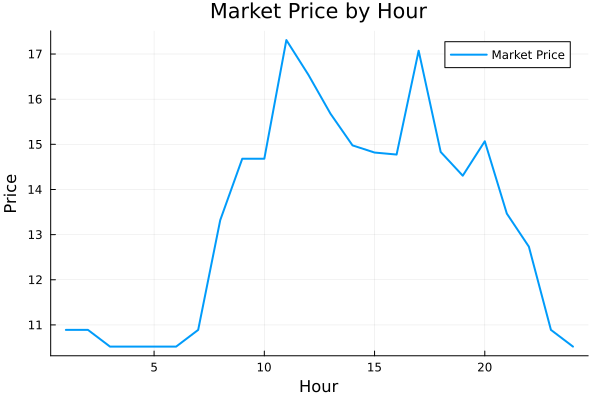

In [37]:
#plot equilibrium_df market_price in a line plot
using Plots
plot(equilibrium_df.hour, equilibrium_df.market_price, label="Market Price", xlabel="Hour", ylabel="Price", title="Market Price by Hour", lw=2)

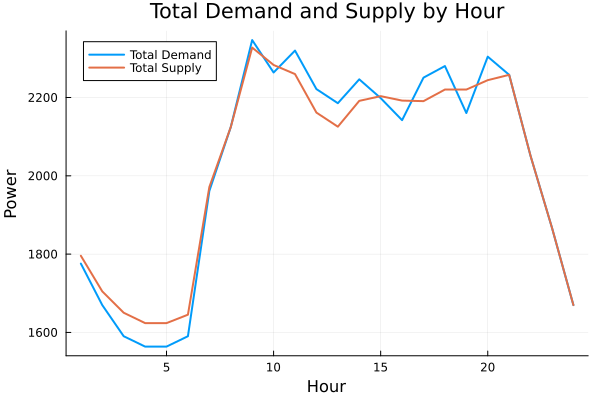

In [38]:
#plot equilibrium_df total_demand and total_supply in a line plot
plot(equilibrium_df.hour, [equilibrium_df.total_demand equilibrium_df.total_supply], label=["Total Demand" "Total Supply"], xlabel="Hour", ylabel="Power", title="Total Demand and Supply by Hour", lw=2)


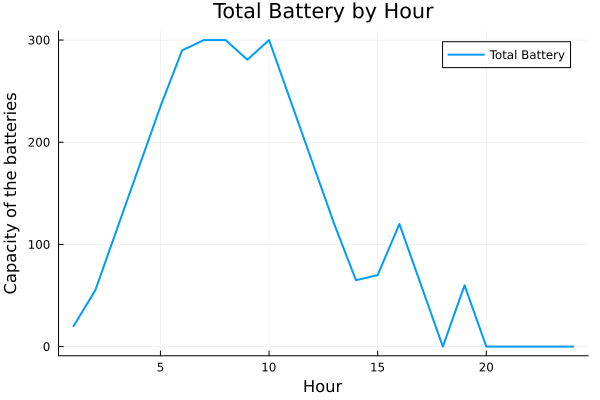

In [39]:
#Plot equilibrium_df total_bat in a line plot
plot(equilibrium_df.hour, equilibrium_df.total_bat, label="Total Battery", xlabel="Hour", ylabel="Capacity of the batteries", title="Total Battery by Hour", lw=2)

In [40]:
#save result_df to csv
CSV.write("results/market_clearing_model2.csv", result_df)

"results/market_clearing_model2.csv"